In [1]:
import torch
import torchvision  
import torch.nn.functional as F  

from torch import optim 
from torch import nn  
from torch.utils.data import DataLoader 

from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
import utils
import nn_model
import itertools

import config
from torchsummary import summary

C:\Users\mati\anaconda3\envs\pytorch_2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
batch_size = 64
input_size = 28*28
lstm_hidden_size = 64
learning_rate = 0.001
num_epochs = 1
num_lstm_layers = 2

## Load data

In [11]:
custom_train_loader = utils.MnistSequences(weak_supervision_rate = 0.2)
custom_test_loader = utils.MnistSequences(train=False)

In [12]:
custom_train_loader.reset()
custom_test_loader.reset()

train_loader = DataLoader(dataset=custom_train_loader, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=custom_test_loader, batch_size=config.BATCH_SIZE, shuffle=True)

## Visualize data

label: tensor(1)


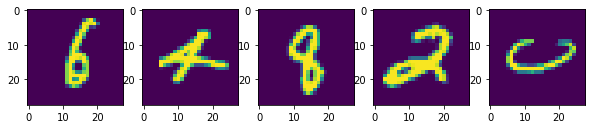

In [13]:
(x, y) = next(iter(train_loader))

columns = len(x[0])
rows = 1
fig = plt.figure(figsize=(10, 10))

for idx in range(1*columns):
    
    image = x[0][idx]
    fig.add_subplot(rows, columns, idx+1)
    plt.imshow(image)
    
print("label:", y[0])

## Model

In [14]:
model = nn_model.LSTM_Model(
    config.INPUT_SIZE, 
    config.LSTM_HIDDEN_SIZE, 
    config.NUM_LSTM_LAYERS, 
    device
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [15]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            73,856
├─LSTM: 1-6                              82,944
├─Linear: 1-7                            130
Total params: 180,226
Trainable params: 180,226
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            73,856
├─LSTM: 1-6                              82,944
├─Linear: 1-7                            130
Total params: 180,226
Trainable params: 180,226
Non-trainable params: 0

In [16]:
def validate(data_loader, model, batches_number):
    N = 0
    num_correct = 0
    
    # Set model to evaluate state
    model.eval()

    with torch.no_grad():
        for x_data, y_data in itertools.islice(data_loader, 0, batches_number):
            
            x_data = x_data.to(device=device).squeeze(1)
            y_data = y_data.to(device=device)

            predictions = model(x_data)
            _, predictions = predictions.max(1)
            num_correct += (predictions == y_data).sum()
            N += predictions.size(0)

    return float(num_correct / N)

In [ ]:
history_1 = []
for epoch in range(config.NUM_EPOCHS):
    for batch_idx, (x_data, y_data) in enumerate(tqdm(train_loader)):

        x_data = x_data.to(device=device).squeeze(1)
        y_data = y_data.to(device=device)

        # forward
        outputs = model(x_data)
        loss = criterion(outputs, y_data)

        # backward
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 50 == 0:
            validation_acc = validate(test_loader, model, 20)
            train_acc = validate(train_loader, model, 20)
            history_1.append((validation_acc,train_acc))
            print("Val acc:",validation_acc, "Train acc:", train_acc)
            
            model.train()
        


  0%|                                                                                | 1/938 [00:08<2:08:10,  8.21s/it]

Val acc: 0.635937511920929 Train acc: 0.5625


  5%|████▍                                                                            | 51/938 [00:29<36:08,  2.44s/it]

Val acc: 0.6117187738418579 Train acc: 0.5570312738418579


 11%|████████▌                                                                       | 101/938 [00:50<34:18,  2.46s/it]

Val acc: 0.609375 Train acc: 0.578906238079071


 16%|████████████▉                                                                   | 151/938 [01:12<34:13,  2.61s/it]

Val acc: 0.632031261920929 Train acc: 0.6000000238418579


 21%|█████████████████▏                                                              | 201/938 [01:33<27:43,  2.26s/it]

Val acc: 0.5640624761581421 Train acc: 0.5367187261581421


 27%|█████████████████████▍                                                          | 252/938 [01:54<21:35,  1.89s/it]

Val acc: 0.9390624761581421 Train acc: 0.7640625238418579


 32%|█████████████████████████▊                                                      | 302/938 [02:15<19:40,  1.86s/it]

Val acc: 0.957812488079071 Train acc: 0.7710937261581421


 37%|█████████████████████████████▉                                                  | 351/938 [02:35<22:55,  2.34s/it]

Val acc: 0.985156238079071 Train acc: 0.782031238079071


 43%|██████████████████████████████████▏                                             | 401/938 [02:57<24:43,  2.76s/it]

Val acc: 0.9234374761581421 Train acc: 0.764843761920929


 48%|██████████████████████████████████████▍                                         | 451/938 [03:18<20:55,  2.58s/it]

Val acc: 0.967968761920929 Train acc: 0.7906249761581421


 53%|██████████████████████████████████████████▋                                     | 501/938 [03:38<17:52,  2.45s/it]

Val acc: 0.9781249761581421 Train acc: 0.7835937738418579


 59%|███████████████████████████████████████████████                                 | 552/938 [04:01<12:20,  1.92s/it]

Val acc: 0.973437488079071 Train acc: 0.7953125238418579


 64%|███████████████████████████████████████████████████▎                            | 602/938 [04:22<09:44,  1.74s/it]

Val acc: 0.983593761920929 Train acc: 0.774218738079071


 70%|███████████████████████████████████████████████████████▌                        | 652/938 [04:43<08:39,  1.82s/it]

Val acc: 0.983593761920929 Train acc: 0.7749999761581421


 73%|██████████████████████████████████████████████████████████▎                     | 684/938 [04:51<01:11,  3.54it/s]

In [22]:
history_temp = history

In [28]:
train_history = [i[0] for i in history]
validation_history = [i[1] for i in history]

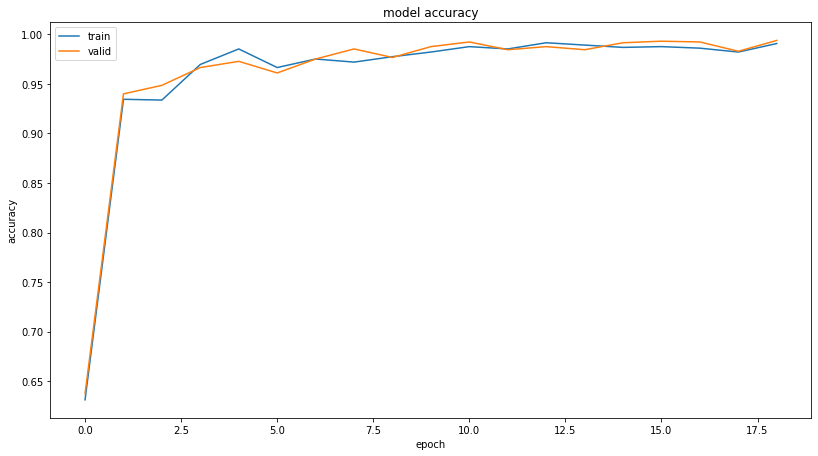

In [31]:
plt.figure(1, figsize = (30,16)) 
    
plt.subplot(221)  
plt.plot(train_history)  
plt.plot(validation_history)  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Test

In [ ]:
def check_accuracy(data_loader, model):
    
    N = 0
    num_correct = 0
    
    # Set model to evaluate state
    model.eval()

    with torch.no_grad():
        for x_data, y_data in data_loader:
            
            x_data = x_data.to(device=device).squeeze(1)
            y_data = y_data.to(device=device)

            predictions = model(x_data)
            _, predictions = predictions.max(1)
            num_correct += (predictions == y_data).sum()
            N += predictions.size(0)

            print("Accuracy", 100. * num_correct / N)


check_accuracy(test_loader, model)

In [30]:

counter = 0
sequ = None
for x, y in test_loader:
    
    sequ = x
    print("L", y)
    
    counter +=1
    if counter >= 1: break

seq_len = len(sequ[0])
print("seq_len:", seq_len)

L tensor([0.9000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.1000, 0.9000, 0.1000,
        0.1000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.9000, 0.1000, 0.9000,
        0.1000, 0.9000, 0.9000, 0.1000, 0.9000, 0.1000, 0.1000, 0.9000, 0.1000,
        0.9000, 0.9000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.1000, 0.9000, 0.9000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.1000, 0.9000, 0.1000, 0.9000, 0.1000, 0.1000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.1000, 0.1000, 0.1000, 0.9000, 0.9000, 0.1000, 0.9000,
        0.9000], dtype=torch.float64)
seq_len: 8


In [32]:
predicted = model(sequ.to(device=device).squeeze(1))
_, predicted = predicted.max(1)
predicted

tensor([0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052, 0.6052,
        0.6052], grad_fn=<ViewBackward0>)